#### Preparations

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import datetime
import os
import time
import seaborn as sns
import json, urllib
import plotly.plotly as py
%matplotlib inline
pal = sns.color_palette()

#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

### just for printing
from IPython.display import Markdown, display_html, display, HTML

def print_style(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
## Displays the first 3 rows 
## as well as the type, the number of na values and the number of unique values in the columns.   
def display_df(df, name, nrows=3):
    df_shape = df.shape
    display(HTML('<h4 style=color:{}><h4>{}</h4></h4>'.format('purple',name)))
    display(HTML('<h4 style=color:{}>{}</h4>'.format('blue', df_shape)))
    display(df.head(nrows))
    display(pd.DataFrame([df.dtypes, np.sum(df.isnull()), df.nunique()],
                         columns=df.dtypes.index,
                         index=['type', 'na', 'nunique']))

In [ ]:
import json, urllib
import plotly.plotly as py
import pandas as pd
import numpy as np

## Data set Overview

In [11]:
# Load subset of the train_sample data
train_smp=pd.read_csv('train_sample.csv',parse_dates=['click_time'])
train_smp.head(3)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0


In [3]:
# Load subset of the training data
train = pd.read_csv('train.csv', nrows=10000000,  parse_dates=['click_time'])
train.head(3)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0


In [4]:
# Load subset of the test data
test= pd.read_csv('test.csv', nrows=10000000, parse_dates=['click_time'])
test.head(3)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00


In [5]:
# Load subset of the test_supplement data
test_su= pd.read_csv('test_supplement.csv', nrows=10000000, parse_dates=['click_time'])
test_su.head(3)

,click_id,ip,app,device,os,channel,click_time
0,0,43570,3,1,18,379,2017-11-09 14:23:39
1,1,80528,3,1,13,379,2017-11-09 14:23:51
2,2,32323,3,1,13,379,2017-11-09 14:25:57


- **ip** : ip address of click 
- **app** : app id for marketing
- **device** : device type of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- **channel** : channel id of mobile and publisher
- **click_time** : timestamp of click(UTC) 
            UTC(Universal Time Coordinated) : 1972년부터 시행된 국제표준시(협정 세계시), 세슘원자의 진동수에 의거한 초의 길이가 기준
            중국은 광활한 영토지만 UTC+8 만 사용
- **attributed_time** : if user download the app for after clicking an ad, this is the time of the app download (**not in the test set**)
- **is_attributed** : binary target to predict(1:downloaded, 0:fraudlent)

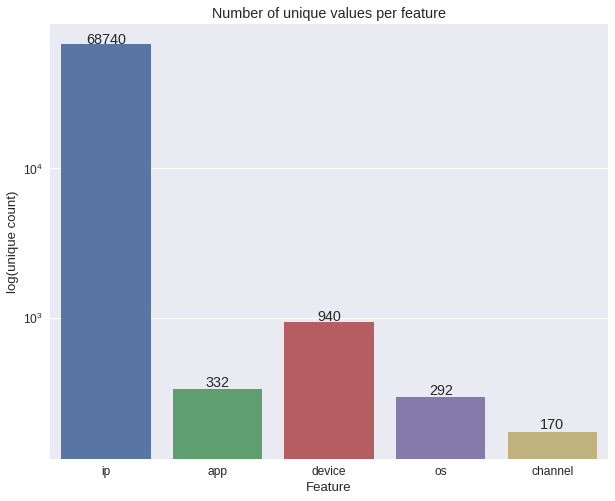

In [21]:
plt.figure(figsize=(10, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

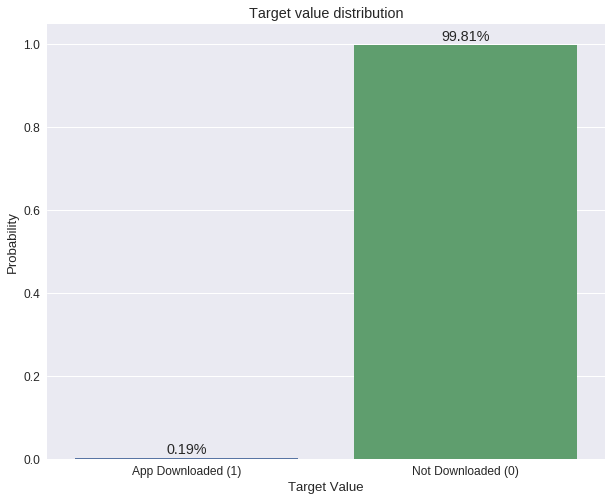

In [45]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 


###### Only 0.2% of the dataset is made up of fradulent clicks. This means that any models we run on the data will either need to be robust against class imbalance or will require some data resampling

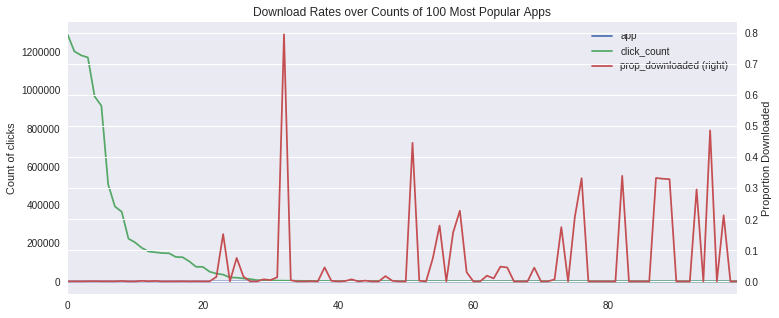

In [42]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Download Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()



In [43]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge[:5])



Count of clicks and proportion of downloads by device:
   device  click_count  prop_downloaded
0       1      9381146         0.001326
1       2       456617         0.000208
2    3032       104393         0.000000
3       0        46476         0.091961
4      59         1618         0.001236


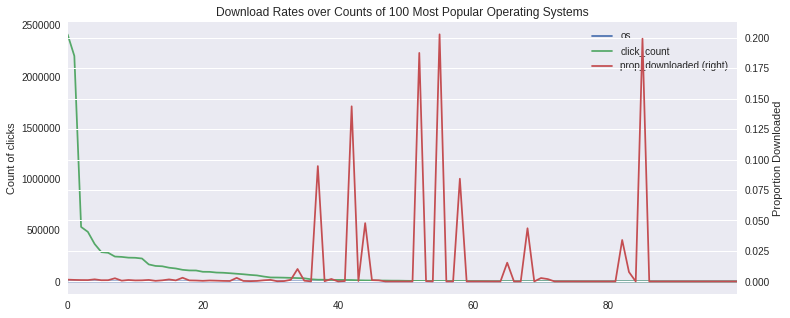

In [38]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Download Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()



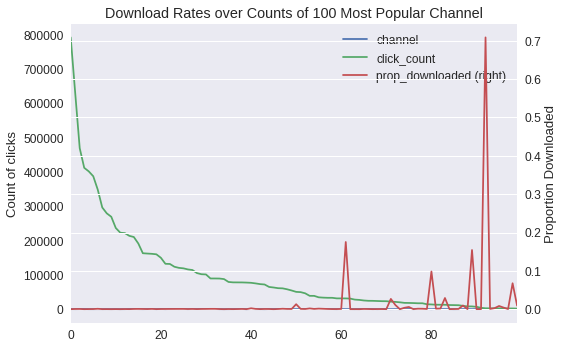

In [47]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Download Rates over Counts of 100 Most Popular Channel')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

### is_attributed  -> highly imbalanced

In [12]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

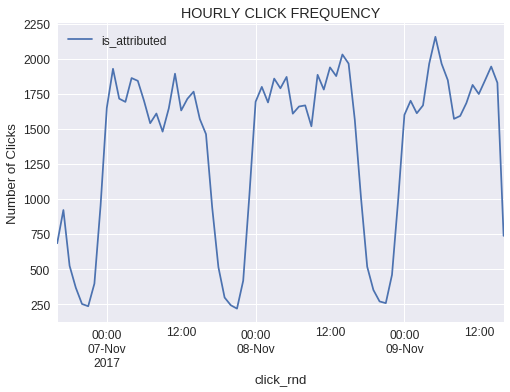

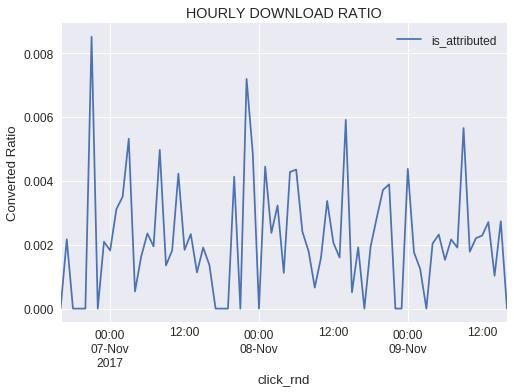

In [25]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY DOWNLOAD RATIO');
plt.ylabel('Converted Ratio');

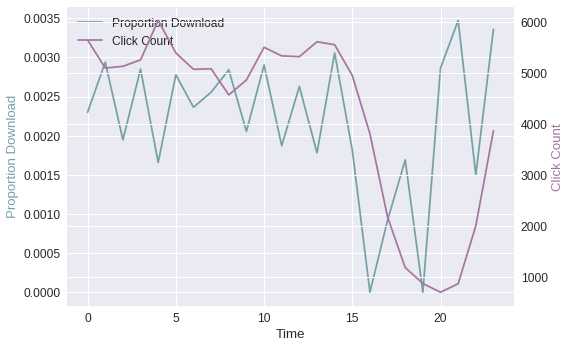

In [23]:
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Download")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Download")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')


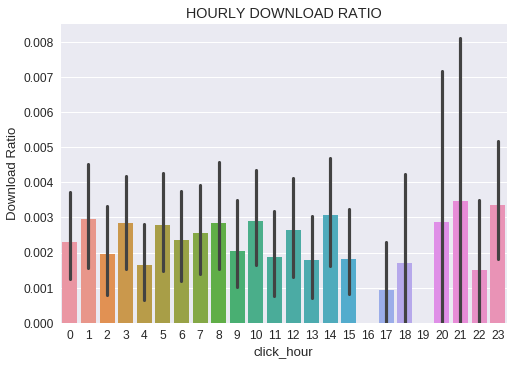

In [24]:
sns.barplot('click_hour', 'is_attributed', data=train_smp)
plt.title('HOURLY DOWNLOAD RATIO');
plt.ylabel('Download Ratio');

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.